 Sample script using EEGNet to classify Event-Related Potential (ERP) EEG data
 from a four-class classification task, using the sample dataset provided in
 the MNE [1, 2] package:
     https://martinos.org/mne/stable/manual/sample_dataset.html#ch-sample-data
   
 The four classes used from this dataset are:
     LA: Left-ear auditory stimulation 
     RA: Right-ear auditory stimulation
     LV: Left visual field stimulation
     RV: Right visual field stimulation

 The code to process, filter and epoch the data are originally from Alexandre
 Barachant's PyRiemann [3] package, released under the BSD 3-clause. A copy of 
 the BSD 3-clause license has been provided together with this software to 
 comply with software licensing requirements. 
 
 When you first run this script, MNE will download the dataset and prompt you
 to confirm the download location (defaults to ~/mne_data). Follow the prompts
 to continue. The dataset size is approx. 1.5GB download. 
 
 For comparative purposes you can also compare EEGNet performance to using 
 Riemannian geometric approaches with xDAWN spatial filtering [4-8] using 
 PyRiemann (code provided below).

 [1] A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck,
     L. Parkkonen, M. Hämäläinen, MNE software for processing MEG and EEG data, 
     NeuroImage, Volume 86, 1 February 2014, Pages 446-460, ISSN 1053-8119.

 [2] A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, 
     R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data 
     analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013.

 [3] https://github.com/alexandrebarachant/pyRiemann. 

 [4] A. Barachant, M. Congedo ,"A Plug&Play P300 BCI Using Information Geometry"
     arXiv:1409.0107. link

 [5] M. Congedo, A. Barachant, A. Andreev ,"A New generation of Brain-Computer 
     Interface Based on Riemannian Geometry", arXiv: 1310.8115.

 [6] A. Barachant and S. Bonnet, "Channel selection procedure using riemannian 
     distance for BCI applications," in 2011 5th International IEEE/EMBS 
     Conference on Neural Engineering (NER), 2011, 348-351.

 [7] A. Barachant, S. Bonnet, M. Congedo and C. Jutten, “Multiclass 
     Brain-Computer Interface Classification by Riemannian Geometry,” in IEEE 
     Transactions on Biomedical Engineering, vol. 59, no. 4, p. 920-928, 2012.

 [8] A. Barachant, S. Bonnet, M. Congedo and C. Jutten, “Classification of 
     covariance matrices using a Riemannian-based kernel for BCI applications“, 
     in NeuroComputing, vol. 112, p. 172-178, 2013.


 Portions of this project are works of the United States Government and are not
 subject to domestic copyright protection under 17 USC Sec. 105.  Those 
 portions are released world-wide under the terms of the Creative Commons Zero 
 1.0 (CC0) license.  
 
 Other portions of this project are subject to domestic copyright protection 
 under 17 USC Sec. 105.  Those portions are licensed under the Apache 2.0 
 license.  The complete text of the license governing this material is in 
 the file labeled LICENSE.TXT that is a part of this project's official 
 distribution. 



In [2]:
import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from EEGModels import EEGNet                
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.metrics import confusion_matrix 
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

while the default tensorflow ordering is 'channels_last' we set it here
to be explicit in case if the user has changed the default ordering

In [3]:
K.set_image_data_format('channels_last')

##################### Process, filter and epoch the data ######################

In [5]:
import scipy.io

data_path = str(sample.data_path())

# Set parameters and read data
raw_fname = data_path + "/MEG/sample/sample_audvis_filt-0-40_raw.fif"
event_fname = data_path + "/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif"
tmin, tmax = -0., 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method='iir')  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
labels = epochs.events[:, -1]

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB



C:\Users\lkcep\AppData\Local\Temp\ipykernel_25204\3129660678.py:26: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()*1000 # format is in (trials, channels, samples)


In [6]:
kernels, chans, samples = 1, 60, 151

# take 50/25/25 percent of the data to train/validate/test
X_train      = X[0:144,]
Y_train      = y[0:144]
X_validate   = X[144:216,]
Y_validate   = y[144:216]
X_test       = X[216:,]
Y_test       = y[216:]

print(Y_train)

[2 3 1 4 2 3 1 4 2 3 1 4 2 3 1 2 3 1 4 2 3 1 4 2 3 1 4 2 3 1 4 2 3 1 2 3 1
 4 2 3 1 4 2 3 1 4 2 3 1 4 2 3 1 4 2 1 4 2 3 1 4 2 3 1 4 2 3 1 4 2 3 1 4 3
 1 4 2 3 1 4 2 3 1 4 2 3 1 4 2 3 1 2 3 1 4 2 3 1 4 2 3 1 4 2 3 1 4 2 3 4 2
 3 1 4 2 3 1 4 2 3 1 4 2 3 1 4 2 3 1 4 2 1 4 2 3 1 4 2 3 1 4 2 3 1]


In [7]:
# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train-1)
Y_validate   = np_utils.to_categorical(Y_validate-1)
Y_test       = np_utils.to_categorical(Y_test-1)
print(Y_train)
# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 4, Chans = chans, Samples = samples, 
               dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()    



[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1.

In [8]:
###############################################################################
# if the classification task was imbalanced (significantly more trials in one
# class versus the others) you can assign a weight to each class during 
# optimization to balance it out. This data is approximately balanced so we 
# don't need to do this, but is shown here for illustration/completeness. 
###############################################################################

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1, 2:1, 3:1}
print(Y_train)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1.

In [10]:
################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
# Riemannian geometry classification (below)
################################################################################

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='D:/shared_git/MasterThesis/scripts/Processing/NNClassification/Examples/checkpoint.keras', verbose=1,
                               save_best_only=True)

# load optimal weights
model.load_weights('D:/shared_git/MasterThesis/scripts/Processing/NNClassification/Examples/EEGNet-8-2-weights.keras')

fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 300, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)

# load optimal weights
model.load_weights('/tmp/checkpoint.keras')

Epoch 1/300

Epoch 1: val_loss improved from inf to 0.45403, saving model to /tmp\checkpoint.keras
9/9 - 25s - loss: 0.1986 - accuracy: 0.9792 - val_loss: 0.4540 - val_accuracy: 0.8056 - 25s/epoch - 3s/step
Epoch 2/300

Epoch 2: val_loss improved from 0.45403 to 0.36260, saving model to /tmp\checkpoint.keras
9/9 - 16s - loss: 0.2834 - accuracy: 0.9306 - val_loss: 0.3626 - val_accuracy: 0.9444 - 16s/epoch - 2s/step
Epoch 3/300

Epoch 3: val_loss did not improve from 0.36260
9/9 - 31s - loss: 0.3101 - accuracy: 0.9236 - val_loss: 0.4385 - val_accuracy: 0.8750 - 31s/epoch - 3s/step
Epoch 4/300

Epoch 4: val_loss did not improve from 0.36260
9/9 - 18s - loss: 0.2714 - accuracy: 0.9028 - val_loss: 0.3874 - val_accuracy: 0.9167 - 18s/epoch - 2s/step
Epoch 5/300

Epoch 5: val_loss did not improve from 0.36260
9/9 - 14s - loss: 0.2492 - accuracy: 0.9653 - val_loss: 0.3908 - val_accuracy: 0.8889 - 14s/epoch - 2s/step
Epoch 6/300

Epoch 6: val_loss did not improve from 0.36260
9/9 - 14s - loss: 

In [ ]:
###############################################################################
# make prediction on test set.
###############################################################################

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Classification accuracy: 0.763889 


In [ ]:
############################# PyRiemann Portion ##############################

# code is taken from PyRiemann's ERP sample script, which is decoding in 
# the tangent space with a logistic regression

n_components = 2  # pick some components

# set up sklearn pipeline
clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(metric='riemann'),
                    LogisticRegression())

preds_rg     = np.zeros(len(Y_test))

# reshape back to (trials, channels, samples)
X_train      = X_train.reshape(X_train.shape[0], chans, samples)
X_test       = X_test.reshape(X_test.shape[0], chans, samples)

# train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
# labels need to be back in single-column format
clf.fit(X_train, Y_train.argmax(axis = -1))
preds_rg     = clf.predict(X_test)

# Printing the results
acc2         = np.mean(preds_rg == Y_test.argmax(axis = -1))
print("Classification accuracy: %f " % (acc2))

# plot the confusion matrices for both classifiers
names        = ['audio left', 'audio right', 'vis left', 'vis right']
plt.figure(0)
confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'EEGNet-8,2')

plt.figure(1)
confusion_matrix(preds_rg, Y_test.argmax(axis = -1), names, title = 'xDAWN + RG')

Classification accuracy: 0.944444 


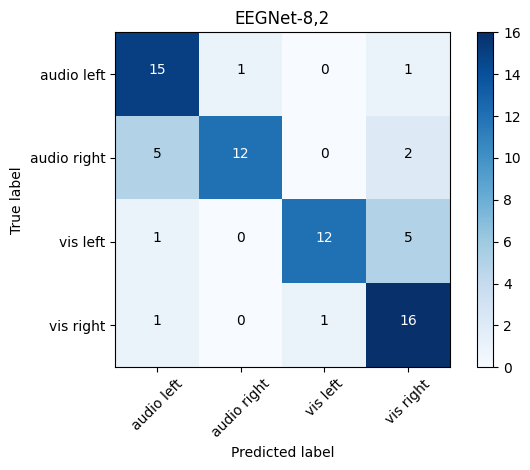

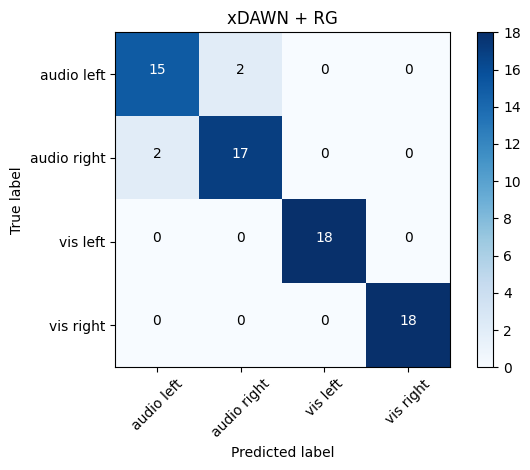

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For enhanced confusion matrix visualization
import itertools  # Import itertools for product function

def plot_confusion_matrix(cm, classes, title):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrices
cm1 = confusion_matrix(Y_test.argmax(axis=-1), preds)
cm2 = confusion_matrix(Y_test.argmax(axis=-1), preds_rg)
names        = ['audio left', 'audio right', 'vis left', 'vis right']

# Plot the confusion matrices
plt.figure(0)
plot_confusion_matrix(cm1, names, 'EEGNet-8,2')

plt.figure(1)
plot_confusion_matrix(cm2, names, 'xDAWN + RG')

plt.show()
